# CLIP on CIFAR10 and Fashion-MNIST dataset
In this assignment, I perform zero-shot prediction using CLIP on CIFAR10 and Fashion-MNIST dataset.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10
from torchvision.datasets import FashionMNIST
from torchvision import datasets
from torchvision import transforms
import torchvision

from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from clip import clip

import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

### Device

In [2]:
device = device = "cuda:0" if torch.cuda.is_available() else "cpu"

### CIFAR10 Dataset

In [3]:
BATCH_SIZE = 128
transform_cifar10 = transforms.Compose([
    transforms.Resize(size=224),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
CIFAR10_train_set = torchvision.datasets.CIFAR10(root='../data', train=True,download=True, transform=transform_cifar10)
CIFAR10_train_dataloader = torch.utils.data.DataLoader(CIFAR10_train_set, batch_size=BATCH_SIZE,shuffle=True, num_workers=2)
CIFAR10_test_set = torchvision.datasets.CIFAR10(root='/shareddata', train=False,download=True, transform=transform_cifar10)
CIFAR10_test_dataloader = torch.utils.data.DataLoader(CIFAR10_test_set, batch_size=BATCH_SIZE,shuffle=False, num_workers=2)
CIFAR10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
CIFAR10_dataset_name = 'CIFAR10'

Files already downloaded and verified
Files already downloaded and verified


### Fashion-MNIST dataset

In [4]:
transform_fashion_mnist = transforms.Compose([
    transforms.Resize(size=224),
    transforms.CenterCrop(size=(224, 224)),
    transforms.Grayscale(3),  # Convert to RGB
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
fashion_test_set = FashionMNIST(root='./data', train=False, download=True, transform=transform_fashion_mnist)
fashion_test_dataloader = DataLoader(fashion_test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
fashion_train_set = FashionMNIST(root='./data', train=True, download=True, transform=transform_fashion_mnist)
fashion_train_dataloader = DataLoader(fashion_train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
fashion_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
fashion_dataset_name = 'FashionMNIST'

### Model

In [5]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [6]:
# CLIP
VISUAL_BACKBONE = ['RN50','RN101','ViT-B/32','ViT-B/16']
model, preprocess = clip.load(name=VISUAL_BACKBONE[0], device=device, download_root='/shareddata/clip/')

### Prompt Gereration & Zero-shot inference

In [7]:
def model_inference(model, image,class_names):
    prompt = "asdqwedqwdwda"
    text_inputs = torch.cat([clip.tokenize(f"{prompt} {c}") for c in class_names]).to(device)
    image_features = model.encode_image(image)
    text_features = model.encode_text(text_inputs)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    logit_scale = model.logit_scale.exp()
    logits = logit_scale * image_features @ text_features.t()
    return logits

### Zero-shot performance

In [8]:
def evaluate_model(visual_backbones, dataloader, dataset_name,class_names):
    model, preprocess = clip.load(name=visual_backbones, device=device, download_root='/shareddata/clip/')
    model.to(device)

    testing_loss = []
    testing_acc = []
    iteration_times = []

    with torch.no_grad():
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        all_preds = []
        all_targets = []
        start_time = time.time()

        for batch_idx, (image, target) in enumerate(dataloader):
            image = image.to(device)
            target = target.to(device)

            # Test model
            logits = model_inference(model, image,class_names)
            _, preds = torch.max(logits, 1)
            val_corrects += torch.sum(preds == target.data)
            # Collect predictions and targets for later evaluation
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

        # Calculate total time for evaluation
        end_time = time.time()
        evaluation_time = end_time - start_time
        iteration_times.append(evaluation_time)
        # Calculate accuracy
        val_acc = val_corrects.double() / len(dataloader.dataset)
        print(f"The zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {visual_backbones}.")
        print(f"Evaluation time: {evaluation_time:.2f} seconds")

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(all_targets, all_preds)
        # Calculate accuracy, precision, recall, and F1 score
        acc = accuracy_score(all_targets, all_preds)
        precision = precision_score(all_targets, all_preds, average='weighted', zero_division=1)
        recall = recall_score(all_targets, all_preds, average='weighted')
        f1 = f1_score(all_targets, all_preds, average='weighted')
        print(f"Accuracy: {acc*100:.2f}%")
        print(f"Precision: {precision*100:.2f}%")
        print(f"Recall: {recall*100:.2f}%")
        print(f"F1 Score: {f1*100:.2f}%\n")
        return val_acc,evaluation_time,conf_matrix

The zero-shot performance on FashionMNIST is 53.91%, visual encoder is RN50.
Evaluation time: 21.52 seconds
Accuracy: 53.91%
Precision: 64.98%
Recall: 53.91%
F1 Score: 49.78%

The zero-shot performance on CIFAR10 is 54.95%, visual encoder is RN50.
Evaluation time: 20.69 seconds
Accuracy: 54.95%
Precision: 62.23%
Recall: 54.95%
F1 Score: 54.00%

The zero-shot performance on FashionMNIST is 47.34%, visual encoder is RN101.
Evaluation time: 28.78 seconds
Accuracy: 47.34%
Precision: 66.45%
Recall: 47.34%
F1 Score: 44.26%

The zero-shot performance on CIFAR10 is 57.92%, visual encoder is RN101.
Evaluation time: 28.76 seconds
Accuracy: 57.92%
Precision: 69.52%
Recall: 57.92%
F1 Score: 56.20%

The zero-shot performance on FashionMNIST is 66.42%, visual encoder is ViT-B/32.
Evaluation time: 12.00 seconds
Accuracy: 66.42%
Precision: 64.30%
Recall: 66.42%
F1 Score: 63.61%

The zero-shot performance on CIFAR10 is 85.15%, visual encoder is ViT-B/32.
Evaluation time: 12.03 seconds
Accuracy: 85.15%


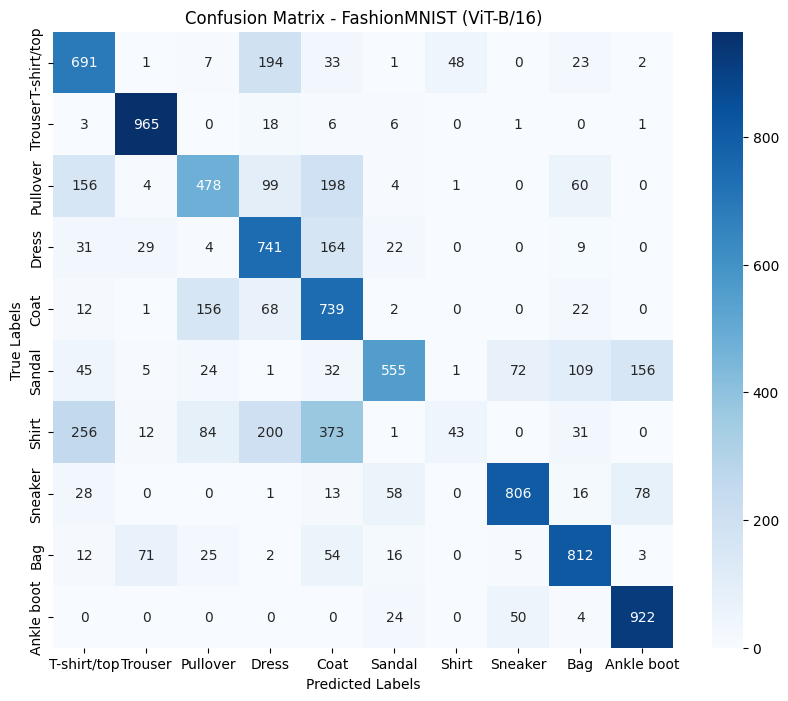

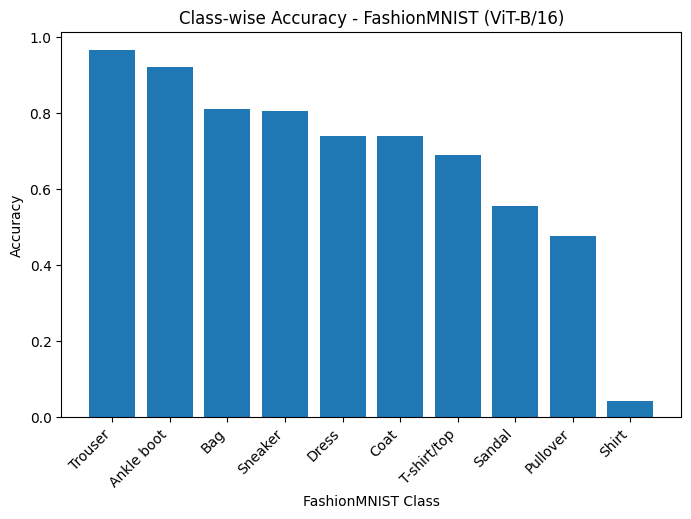

The zero-shot performance on CIFAR10 is 86.83%, visual encoder is ViT-B/16.
Evaluation time: 33.19 seconds
Accuracy: 86.83%
Precision: 87.75%
Recall: 86.83%
F1 Score: 86.85%



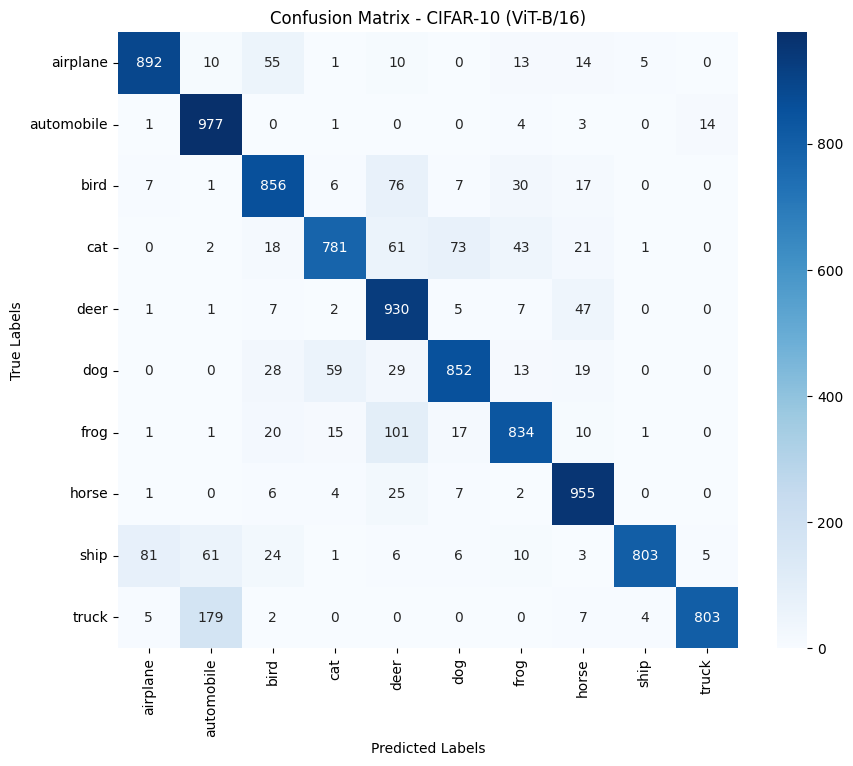

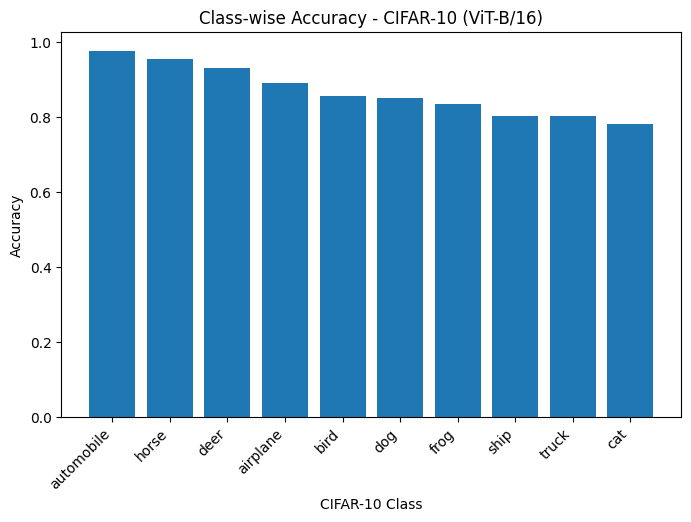

In [9]:
# Lists to store accuracy values for each dataset and confusion matrices
fashion_accs = []
cifar10_accs = []
fashion_iteration_times = []
cifar10_iteration_times = []
fashion_class_accuracies = {}  # Dictionary to store class accuracies for FashionMNIST
cifar10_class_accuracies = {}  # Dictionary to store class accuracies for CIFAR-10

# Iterate over visual backbones and evaluate on both datasets
for visual_backbones in VISUAL_BACKBONE:
    is_vit_b_16 = 'ViT-B/16'
    fashion_acc, fashion_times, fashion_conf_matrix = evaluate_model(visual_backbones, fashion_test_dataloader, fashion_dataset_name, fashion_class_names)
    fashion_accs.append(fashion_acc)
    if is_vit_b_16 == visual_backbones:
        fashion_iteration_times.append(fashion_times)
        # Calculate and store class accuracies for FashionMNIST
        # Visualize confusion matrix for FashionMNIST using ViT-B/16
        plt.figure(figsize=(10, 8))
        sns.heatmap(fashion_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=fashion_class_names, yticklabels=fashion_class_names)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix - FashionMNIST (ViT-B/16)")
        plt.show()
        for i, class_name in enumerate(fashion_class_names):
            class_accuracy = fashion_conf_matrix[i, i] / np.sum(fashion_conf_matrix[i, :])
            fashion_class_accuracies[class_name] = class_accuracy
        
        # Sort and visualize class accuracies
        sorted_fashion_accuracies = sorted(fashion_class_accuracies.items(), key=lambda x: x[1], reverse=True)
        plt.figure(figsize=(8, 5))
        plt.bar(*zip(*sorted_fashion_accuracies))
        plt.xlabel("FashionMNIST Class")
        plt.ylabel("Accuracy")
        plt.title("Class-wise Accuracy - FashionMNIST (ViT-B/16)")
        plt.xticks(rotation=45, ha="right")
        plt.show()

    cifar10_acc, cifar10_times, cifar10_conf_matrix = evaluate_model(visual_backbones, CIFAR10_test_dataloader, CIFAR10_dataset_name, CIFAR10_class_names)
    cifar10_accs.append(cifar10_acc)
    if is_vit_b_16 == visual_backbones:
        cifar10_iteration_times.append(cifar10_times)
        # Visualize confusion matrix for CIFAR-10 using ViT-B/16
        plt.figure(figsize=(10, 8))
        sns.heatmap(cifar10_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=CIFAR10_class_names, yticklabels=CIFAR10_class_names)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix - CIFAR-10 (ViT-B/16)")
        plt.show()
        # Calculate and store class accuracies for CIFAR-10
        for i, class_name in enumerate(CIFAR10_class_names):
            class_accuracy = cifar10_conf_matrix[i, i] / np.sum(cifar10_conf_matrix[i, :])
            cifar10_class_accuracies[class_name] = class_accuracy
        
        # Sort and visualize class accuracies
        sorted_cifar10_accuracies = sorted(cifar10_class_accuracies.items(), key=lambda x: x[1], reverse=True)
        plt.figure(figsize=(8, 5))
        plt.bar(*zip(*sorted_cifar10_accuracies))
        plt.xlabel("CIFAR-10 Class")
        plt.ylabel("Accuracy")
        plt.title("Class-wise Accuracy - CIFAR-10 (ViT-B/16)")
        plt.xticks(rotation=45, ha="right")
        plt.show()


## Baseline Model
---
### Hyperparameters

In [10]:
BATCH_SIZE = 128  #每次训练迭代使用的数据样本数量为128
EPOCHS = 3
LEARNING_RATE = 0.001

### Model

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 32 * 56 * 56)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [12]:
model = SimpleCNN(num_classes=10).to(device)

### Optimizer

In [17]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Loss Function

In [18]:
criterion = nn.CrossEntropyLoss()

### Train and Test Baseline Model

In [19]:
def train_and_evaluate(model, train_dataloader, test_dataloader, criterion, optimizer, device, epochs,class_names):
    iteration_times = []
    total_train_time = 0.0
    total_eval_time = 0.0

    for epoch in range(epochs):
        start_time = time.time()
        # Training
        model.train()
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Record end time for the training epoch
        end_time_train = time.time()
        training_time = end_time_train - start_time
        total_train_time += training_time
        iteration_times.append(total_train_time)

        # Evaluation on the test set
        model.eval()
        true_labels = []
        predicted_labels = []
        
        with torch.no_grad():
            for images, labels in test_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(predicted.cpu().numpy())

        end_time_eval = time.time()
        evaluation_time = end_time_eval - end_time_train
        total_eval_time += evaluation_time

    # Output confusion matrix heatmap
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix Heatmap")
    plt.show()

    # Calculate final metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    print(f"Final Metrics: "
          f"Accuracy: {accuracy:.4f}, "
          f"Precision: {precision:.4f}, "
          f"Recall: {recall:.4f}, "
          f"F1 Score: {f1:.4f}")
    print(f"Total Training Time: {total_train_time:.2f} seconds")
    print(f"Total Evaluation Time: {total_eval_time:.2f} seconds")

    return accuracy, iteration_times


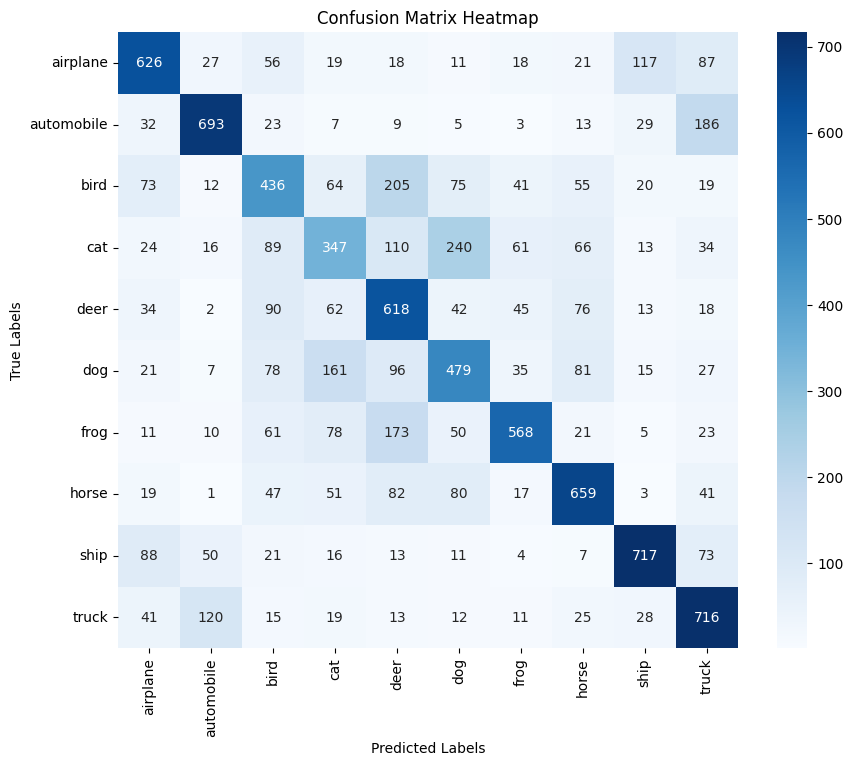

Final Metrics: Accuracy: 0.5859, Precision: 0.5904, Recall: 0.5859, F1 Score: 0.5850
Total Training Time: 192.13 seconds
Total Evaluation Time: 23.98 seconds


In [20]:
baseline_cifar10, iteration_times_cifar10 = train_and_evaluate(model, CIFAR10_train_dataloader, CIFAR10_test_dataloader, criterion, optimizer, device, EPOCHS,CIFAR10_class_names)

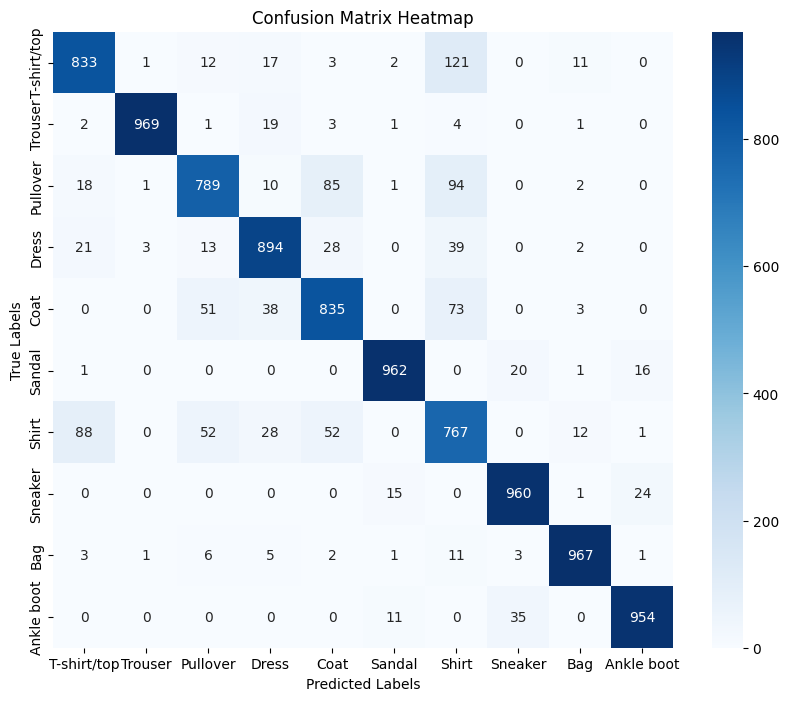

Final Metrics: Accuracy: 0.8930, Precision: 0.8951, Recall: 0.8930, F1 Score: 0.8937
Total Training Time: 227.95 seconds
Total Evaluation Time: 23.07 seconds


In [93]:
baseline_fashion, iteration_times_fashion = train_and_evaluate(model, fashion_train_dataloader, fashion_test_dataloader, criterion, optimizer, device, EPOCHS,fashion_class_names)

In [78]:
#Convert tensors to NumPy arrays on the CPU
fashion_accs_cpu = [acc.item() for acc in fashion_accs]
cifar10_accs_cpu = [acc.item() for acc in cifar10_accs]
cifar10_accs_cpu.append(baseline_cifar10)
fashion_accs_cpu.append(baseline_fashion)

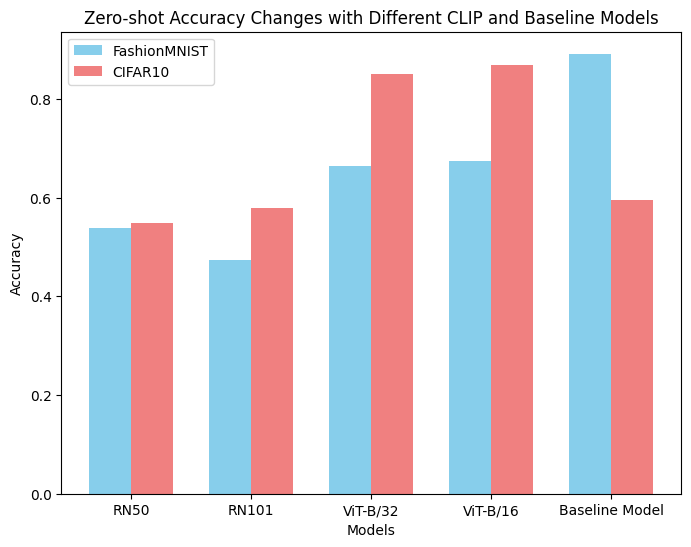

In [85]:
# Visualize the accuracy changes as a bar chart with custom colors
plt.figure(figsize=(8, 6))
bar_width = 0.35
# Position for each group of bars
r1 = range(len(x))
r2 = [i + bar_width for i in r1]
# Set custom colors
color_fashion = 'skyblue'
color_cifar10 = 'lightcoral'
# Plot the bars for FashionMNIST and CIFAR10 with custom colors
plt.bar(r1, fashion_accs_cpu, width=bar_width, label='FashionMNIST', color=color_fashion)
plt.bar(r2, cifar10_accs_cpu, width=bar_width, label='CIFAR10', color=color_cifar10)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Zero-shot Accuracy Changes with Different CLIP and Baseline Models')
plt.xticks([r + bar_width / 2 for r in range(len(x))], x)
plt.legend()
plt.show()